In [1]:
import time
from time import perf_counter

# Data processing.
import json
import numpy as np
import pandas as pd

# Plotting.
import matplotlib.pyplot as plt
%matplotlib notebook

# "Vanilla" python parallelism.
import multiprocessing

# Scalable data analytics: dask.
import dask
import dask.bag as db
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import graphviz

# For GC large pandas dataframes after use.
import gc

# Ignore warnings.
import warnings
warnings.simplefilter("ignore")

# Load Data

In [2]:
# This lazily creates a timeseries dataset for us with around 7.6M rows.
dd_df = dd.demo.make_timeseries(start='2018-01-01',
                                end='2018-03-30',
                                dtypes={'x': float, 'y': float, 'id': int},
                                freq='1s',
                                partition_freq='24h')

dd_df

,id,x,y
npartitions=88,,,
2018-01-01,int64,float64,float64
2018-01-02,...,...,...
...,...,...,...
2018-03-29,...,...,...
2018-03-30,...,...,...


In [3]:
dd_df.head()

,id,x,y
timestamp,,,
2018-01-01 00:00:00,1034,0.702573,0.925905
2018-01-01 00:00:01,1015,-0.909530,0.439631
2018-01-01 00:00:02,994,0.290274,-0.399294
2018-01-01 00:00:03,981,-0.339153,0.733781
2018-01-01 00:00:04,1005,-0.840813,-0.504366


# Start Client

In [4]:
n_cores = multiprocessing.cpu_count()
print('number of cores: ', n_cores)

number of cores:  4


In [5]:
cluster = LocalCluster(ip=None, n_workers=n_cores, processes=True)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42515 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.14 GB


# Q2

In [23]:
runtime_df = pd.DataFrame(columns=['n_cores','runtime (ms)'])

n_workers = 1
while n_workers <= n_cores:
    print('Resizing cluster to %s worker(s)...' % n_workers)
    cluster.scale(n_workers)
    time.sleep(1)
    
    t_start = perf_counter()
    dd_df.y.rolling('5min').mean().loc['2018-01-01':'2018-01-31'].compute()
    t_stop = perf_counter()
    
    runtime = (t_stop - t_start)*1000
    runtime_df = runtime_df.append({'n_cores': n_workers,'runtime (ms)': runtime},ignore_index=True)
    print('dask time (ms): ', runtime)
    n_workers *= 2;

Resizing cluster to 1 worker(s)...
dask time (ms):  1910.443300002953
Resizing cluster to 2 worker(s)...
dask time (ms):  2538.1376999939675
Resizing cluster to 4 worker(s)...
dask time (ms):  3287.3079999990296


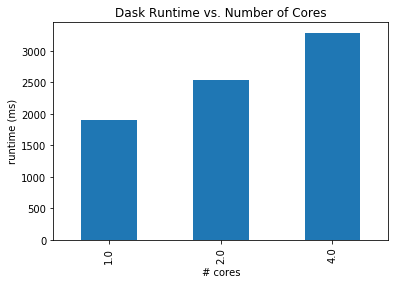

In [28]:
runtime_df.plot(x='n_cores',y='runtime (ms)',kind='bar',legend=False)
plt.title('Dask Runtime vs. Number of Cores')
plt.xlabel('# cores')
plt.ylabel('runtime (ms)')
plt.savefig('images/q2.png')

In [31]:
t_1 = perf_counter()
df = dd_df.compute()
t_2 = perf_counter()
df.y.rolling('5min').mean().loc['2018-01-01':'2018-01-31']
t_3 = perf_counter()
print('Pandas time for computation only (ms): %s' % ((t_3 - t_2)*1000))
print('Pandas time with table conversion (ms): %s' % ((t_3 - t_1)*1000))

# GC pandas df.
del df
gc.collect()

Pandas time for computation only (ms): 1247.863899996446
Pandas time with table conversion (ms): 5711.919199995464


2325

In [27]:
df = dd_df.compute()
df.y.rolling('5min').mean().loc['2018-01-01':'2018-01-31']

timestamp
2018-01-01 00:00:00    0.925905
2018-01-01 00:00:01    0.682768
2018-01-01 00:00:02    0.322081
2018-01-01 00:00:03    0.425006
2018-01-01 00:00:04    0.239132
                         ...   
2018-01-31 23:59:55    0.015864
2018-01-31 23:59:56    0.017285
2018-01-31 23:59:57    0.018903
2018-01-31 23:59:58    0.017789
2018-01-31 23:59:59    0.017530
Freq: S, Name: y, Length: 2678400, dtype: float64

# Q3

In [10]:
urls = (db.read_text('https://archive.analytics.mybinder.org/index.jsonl')
                    .map(json.loads)
                    .pluck('name')
                    .compute())
urls = ['https://archive.analytics.mybinder.org/' + u for u in urls]
notebook_runs = db.read_text(urls).map(json.loads)

In [11]:
notebook_runs.filter(lambda record: record['timestamp'].startswith('2019-08')).pluck('provider').frequencies(sort=True).take(2)

(('GitHub', 374145), ('Gist', 5894))

In [12]:
runs_df = notebook_runs.to_dataframe()
runs_df[runs_df['timestamp'].str.startswith('2019-08')].provider.value_counts().nlargest(2).compute()

GitHub    374145
Gist        5894
Name: provider, dtype: int64

In [13]:
runtime_df_q3 = pd.DataFrame(columns=['n_cores','runtime (ms)'])

n_workers = 1
while n_workers <= n_cores:
    print('Resizing cluster to %s worker(s)...' % n_workers)
    cluster.scale(n_workers)
    time.sleep(1)
    
    t_start = perf_counter()
    (notebook_runs.filter(lambda record: record['timestamp'].startswith('2019-08'))
                 .pluck('provider').frequencies(sort=True).take(2))
    t_stop = perf_counter()
    
    runtime = (t_stop - t_start)*1000
    runtime_df_q3 = runtime_df_q3.append({'n_cores': n_workers,'runtime (ms)': runtime},ignore_index=True)
    print('dask time (ms): ', runtime)
    n_workers *= 2

Resizing cluster to 1 worker(s)...
dask time (ms):  322395.9199000019
Resizing cluster to 2 worker(s)...
dask time (ms):  191198.12199999433
Resizing cluster to 4 worker(s)...
dask time (ms):  158067.04860000173


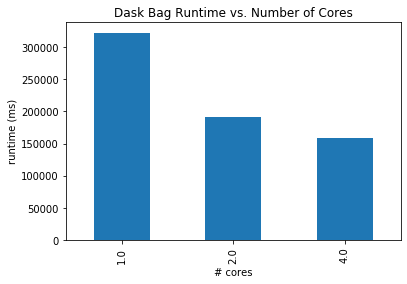

In [32]:
runtime_df_q3.plot(x='n_cores',y='runtime (ms)',kind='bar',legend=False)
plt.title('Dask Bag Runtime vs. Number of Cores')
plt.xlabel('# cores')
plt.ylabel('runtime (ms)')
plt.savefig('images/q3.png')

In [15]:
runtime_df_q3_2 = pd.DataFrame(columns=['n_cores','pipeline runtime (ms)','computation runtime (ms)'])

n_workers = 1
while n_workers <= n_cores:
    print('Resizing cluster to %s worker(s)...' % n_workers)
    cluster.scale(n_workers)
    time.sleep(1)
    
    t1 = perf_counter()
    runs_df = notebook_runs.to_dataframe()
    t2 = perf_counter()
    runs_df[runs_df['timestamp'].str.startswith('2019-08')].provider.value_counts().nlargest(2).compute()
    t3 = perf_counter()
    
    total_runtime = (t3 - t1)*1000
    comp_runtime = (t3 - t2)*1000
    runtime_df_q3_2 = runtime_df_q3_2.append({'n_cores': n_workers,
                                              'pipeline runtime (ms)': total_runtime,
                                              'computation runtime (ms)': comp_runtime},
                                             ignore_index=True)
    print('computation time (ms): ', comp_runtime)
    print('pipeline runtime (ms): ', total_runtime)
    n_workers *= 2

Resizing cluster to 1 worker(s)...
computation time (ms):  344221.50160000456
pipeline runtime (ms):  345122.7319000027
Resizing cluster to 2 worker(s)...
computation time (ms):  225037.7512999985
pipeline runtime (ms):  226004.4448999979
Resizing cluster to 4 worker(s)...
computation time (ms):  192420.03690000274
pipeline runtime (ms):  194219.77809999953


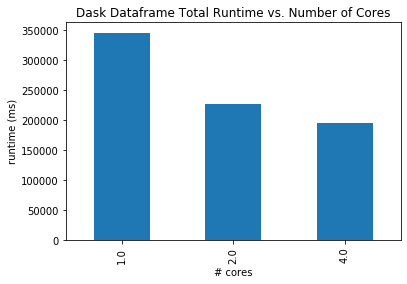

In [16]:
runtime_df_q3_2.plot(x='n_cores',y='pipeline runtime (ms)',kind='bar',legend=False)
plt.title('Dask Dataframe Pipeline Runtime vs. Number of Cores')
plt.xlabel('# cores')
plt.ylabel('runtime (ms)')
plt.savefig('images/q3_df_total.png')

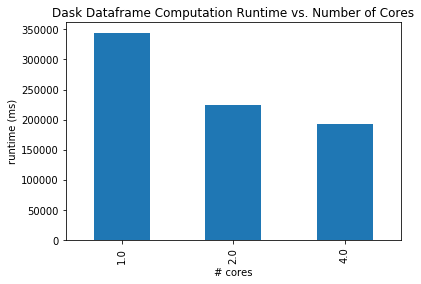

In [17]:
runtime_df_q3_2.plot(x='n_cores',y='computation runtime (ms)',kind='bar',legend=False)
plt.title('Dask Dataframe Computation Runtime vs. Number of Cores')
plt.xlabel('# cores')
plt.ylabel('runtime (ms)')
plt.savefig('images/q3_df_comp.png')